#  Ubiquant Market Prediction with DNN
In this notebook, I will build a Ubiquant Market Prediction Model with TensorFlow DNN. 
I will train the Model using CombinatorialPurgedGroupKFold CV strategy. You can find more detials in this [discussion](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305118).
In other to train the Model for 5 folds in a single run and avoid OOM error, I made a TF-record dataset in notebook [UMP TF-Record: CombinatorialPurgedGroupKFold](https://www.kaggle.com/lonnieqin/ump-tf-record-combinatorialpurgedgroupkfold).
## Import Packages

In [1]:
# Google Colabで、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

#/root/.kaggleを作成して、apiを使えるようにする。
!sudo mkdir /root/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json /root/.kaggle/kaggle.json

# cdは!が使えない。マジックコマンド%で移動
%cd /content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction
%ls -a

Mounted at /content/drive
/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction
checkpoint                               model.png
example_sample_submission.parquet        protos/
example_test.parquet                     tf_datas/
.git/                                    tf_models/
holidays_of_china_from_2014_to_2030.csv  train_low_mem.parquet
ideas.txt                                train.parquet
investment_ids/                          Ubiquant_Market_Prediction/
investment_ids.csv


In [2]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

from scipy import stats

import time
from tqdm.autonotebook import tqdm
from pprint import pprint
import copy
from pathlib import Path
from joblib import Parallel, delayed
import joblib

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  app.launch_new_instance()


## Configuration

In [3]:
class Config:
    seed = 2022

    save_dataset = False
    n_splits = 6
    group_gap = 1

    is_training = True
    model = 'BASE_DNN'
    epochs = 100
    patience = 20
    lr = 1e-4
    lr_scheduler = 'WarmUpCosineDecayScheduler'
    batch_size = 4096

    tf_record_dataset_path = "./tf_datas"
    output_dataset_path = "./tf_models"

    def warm_up_lr(self, data_length):
        total_steps = int(self.epochs * data_length/self.batch_size)
        warmup_lr = 0.0
        warmup_steps = 10
        hold_base_rate_steps = 0
        return (self.lr, total_steps, warmup_lr, warmup_steps, hold_base_rate_steps)

config = Config()

## Time Series Split

In [4]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [5]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))
# HOW TO USE WarmUpCosineDecayScheduler(keras.callbacks.Callback):
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# # Create a model.
# def dummy_model():
#     inputs = tf.keras.Input((100, ), dtype=tf.float32)
#     x = layers.Dense(32, activation='swish')(inputs)
#     x = layers.Dense(10, activation='softmax')(inputs)

#     opt = tf.optimizers.Adam(config.lr)
#     model.compile(optimizer=opt,
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])
#     return model

# # Number of training samples.
# sample_count = 12

# # Total epochs to train.
# epochs = 100

# # Number of warmup epochs.
# warmup_epoch = 10

# # Training batch size, set small value here for demonstration purpose.
# batch_size = 4

# # Base learning rate after warmup.
# learning_rate_base = 0.001
# total_steps = int(epochs * sample_count / batch_size)

# # Compute the number of warmup batches.
# warmup_steps = int(warmup_epoch * sample_count / batch_size)

# # Generate dummy data.
# data = np.random.random((sample_count, 100))
# labels = np.random.randint(10, size=(sample_count, 1))

# # Convert labels to categorical one-hot encoding.
# one_hot_labels = keras.utils.to_categorical(labels, num_classes=10)

# # Compute the number of warmup batches.
# warmup_batches = warmup_epoch * sample_count / batch_size

# # Create the Learning rate scheduler.
# warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
#                                         total_steps=total_steps,
#                                         warmup_learning_rate=0.0,
#                                         warmup_steps=warmup_steps,
#                                         hold_base_rate_steps=0)

# # Train the model, iterating on the data in batches of 32 samples
# model = dummy_model()
# model.fit(data, one_hot_labels, epochs=epochs, batch_size=batch_size,
#         verbose=0, callbacks=[warm_up_lr])

# import matplotlib.pyplot as plt
# plt.plot(warm_up_lr.learning_rates)
# plt.xlabel('Step', fontsize=20)
# plt.ylabel('lr', fontsize=20)
# plt.axis([0, total_steps, 0, learning_rate_base*1.1])
# plt.xticks(np.arange(0, total_steps, 50))
# plt.grid()
# plt.title('Cosine decay with warmup', fontsize=20)
# plt.show()

## Reading Data

In [ ]:
%%time
train = pd.read_parquet('train.parquet')
print(train.info())
train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float64(301), int64(2), object(1)
memory usage: 7.1+ GB
None
CPU times: user 21.1 s, sys: 16.7 s, total: 37.8 s
Wall time: 1min


## Create CV and Save datasets

In [6]:
def create_record(i):
    dic = {}
    dic[f"features"] = tf.train.Feature(float_list=tf.train.FloatList(value=list(train.iloc[i])))
    dic["time_id"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[time_id.iloc[i]]))
    dic["investment_id"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[investment_id.iloc[i]]))
    dic["target"] = tf.train.Feature(float_list=tf.train.FloatList(value=[y.iloc[i]]))
    record_bytes = tf.train.Example(features=tf.train.Features(feature=dic)).SerializeToString()
    return record_bytes
    
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )

In [7]:
def save_datasets(fold, tra_idx, val_idx):
    if fold==0:
        print('preprocessing')
        investment_id = train.pop('investment_id')
        time_id = train.pop('time_id')
        y = train.pop('target')
        row_id = train.pop('row_id')

    print("=" * 60)
    print(f"Fold : {fold}")
    print("=" * 60)
    print("Train Sample size:", len(tra_idx))
    print("Test Sample size:", len(val_idx))
    train_save_path = f"tf_datas/fold_{fold}_train.tfrecords"
    begin = time.time()

    print(f"Creating {train_save_path}")
    with tf.io.TFRecordWriter(train_save_path) as file_writer:
        for i in tra_idx:
            file_writer.write(create_record(i))
    print("Elapsed time: %.2f"%(time.time() - begin))

    # save validation data
    begin = time.time()
    test_save_path = f"tf_datas/fold_{fold}_test.tfrecords"
    print(f"Creating {test_save_path}")
    with tf.io.TFRecordWriter(test_save_path) as file_writer:
        for i in val_idx:
            file_writer.write(create_record(i))
    print("Elapsed time: %.2f"%(time.time() - begin))
    return

if config.save_dataset:
    gkf = PurgedGroupTimeSeriesSplit(n_splits = config.n_splits, group_gap = config.group_gap)
    result = joblib.Parallel(n_jobs=-1)(joblib.delayed(save_datasets)(fold, tra_idx, val_idx) for fold, (tra_idx, val_idx)\
                                        in enumerate(gkf.split(train['investment_id'].values, train['investment_id'].values, train['time_id'].values)))

In [ ]:
if config.save_dataset:
    gkf = PurgedGroupTimeSeriesSplit(n_splits = config.n_splits, group_gap = config.group_gap)
    for fold, (tra_idx, val_idx) in enumerate(gkf.split(train['investment_id'].values, train['investment_id'].values, train['time_id'].values)):
        if fold==0:
            print('preprocessing')
            investment_id = train.pop('investment_id')
            time_id = train.pop('time_id')
            y = train.pop('target')
            row_id = train.pop('row_id')

        print("=" * 60)
        print(f"Fold : {fold}")
        print("=" * 60)
        print("Train Sample size:", len(tra_idx))
        print("Test Sample size:", len(val_idx))
        train_save_path = f"tf_datas/fold_{fold}_train.tfrecords"
        begin = time.time()

        print(f"Creating {train_save_path}")
        with tf.io.TFRecordWriter(train_save_path) as file_writer:
            for i in tra_idx:
                file_writer.write(create_record(i))
        print("Elapsed time: %.2f"%(time.time() - begin))

        # save validation data
        begin = time.time()
        test_save_path = f"tf_datas/fold_{fold}_test.tfrecords"
        print(f"Creating {test_save_path}")
        with tf.io.TFRecordWriter(test_save_path) as file_writer:
            for i in val_idx:
                file_writer.write(create_record(i))
        print("Elapsed time: %.2f"%(time.time() - begin))

preprocessing
Fold : 0
Train Sample size: 388150
Test Sample size: 379744
Creating tf_datas/fold_0_test.tfrecords
Elapsed time: 135.51
Fold : 1
Train Sample size: 768107
Test Sample size: 353844
Creating tf_datas/fold_1_test.tfrecords
Elapsed time: 124.46
Fold : 2
Train Sample size: 1121522
Test Sample size: 436170
Creating tf_datas/fold_2_test.tfrecords
Elapsed time: 153.06
Fold : 3
Train Sample size: 1557479
Test Sample size: 484549
Creating tf_datas/fold_3_test.tfrecords
Elapsed time: 179.05
Fold : 4
Train Sample size: 2041721
Test Sample size: 533074
Creating tf_datas/fold_4_test.tfrecords
Elapsed time: 194.44
Fold : 5
Train Sample size: 2574611
Test Sample size: 563655
Creating tf_datas/fold_5_test.tfrecords
Elapsed time: 203.09


In [ ]:
# val = train.loc[val_idx, :]
# tra = train.loc[tra_idx, :]
# tra = tra[tra['investment_id']==2]
# val = val[val['investment_id']==2]
# tra['time_id'].unique(), val['time_id'].unique()

## Create an IntegerLookup layer for investment_id input

In [8]:
%%time
investment_ids = pd.read_csv("investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

CPU times: user 580 ms, sys: 486 ms, total: 1.07 s
Wall time: 3.25 s


## Modeling

In [ ]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])

    opt = tf.optimizers.Adam(config.lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        114560      ['integer_lookup[0][0]']         
                                                                                                  
 reshape (Reshape)              (None, 32)           0           ['embedding[0][0]']              
                                                                                              

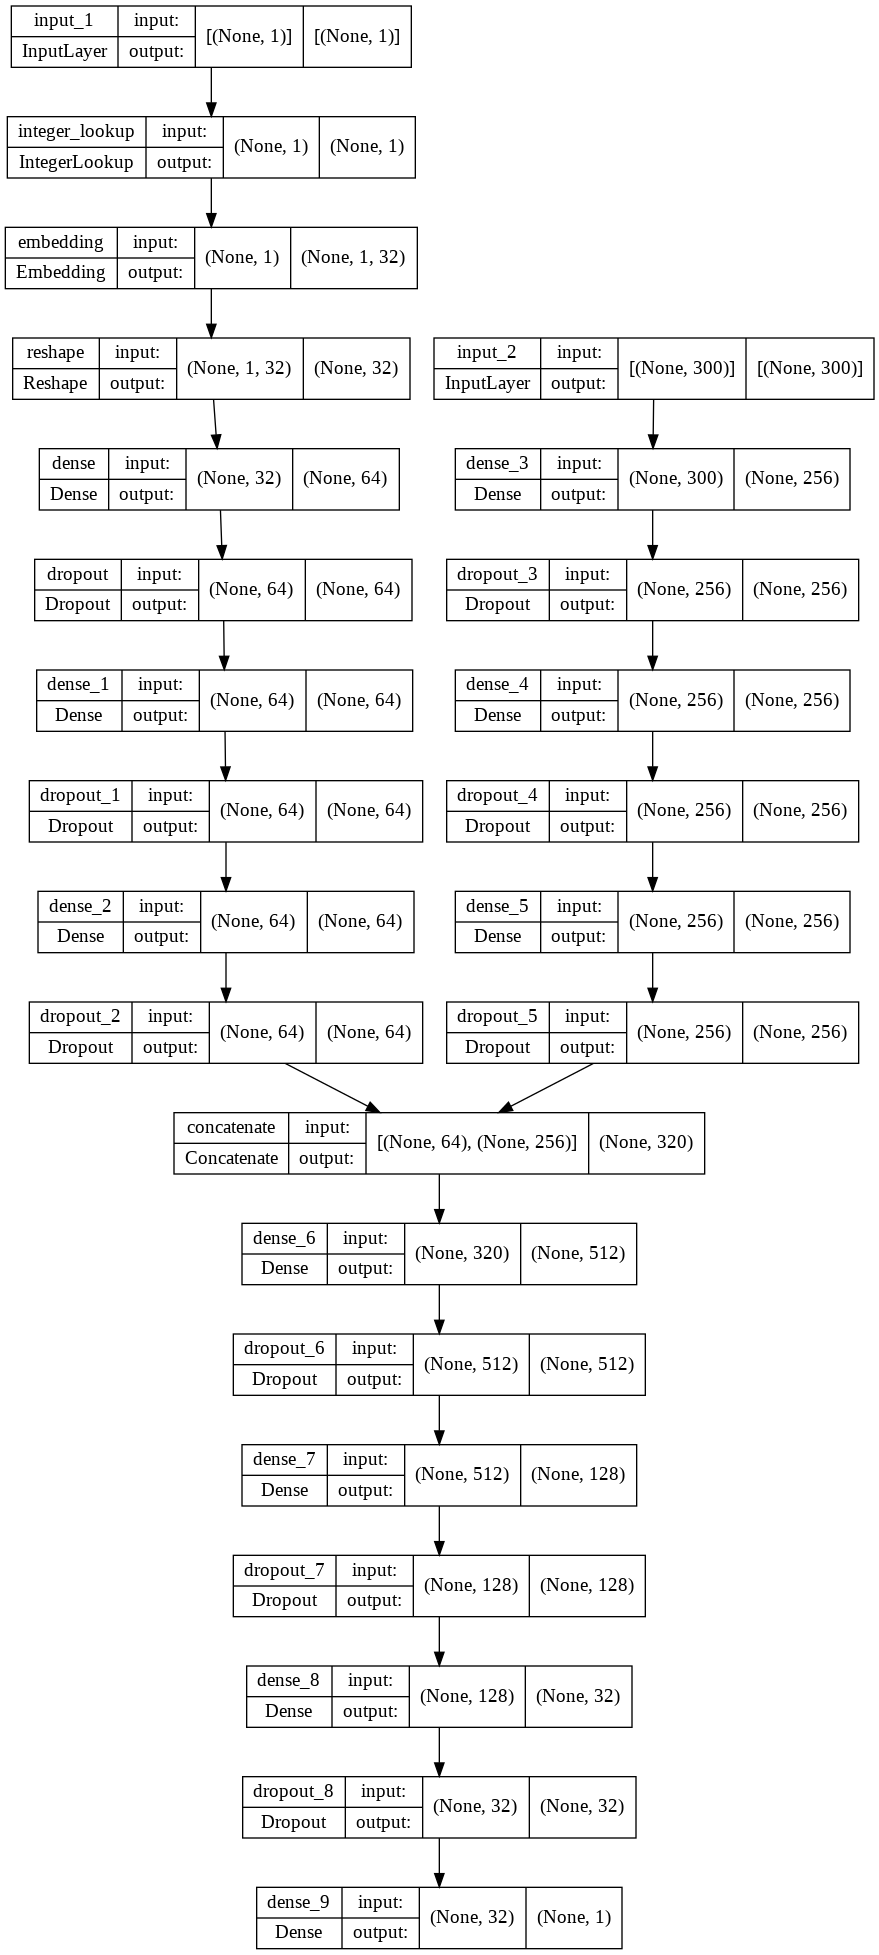

In [ ]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Make Tensorflow dataset

In [ ]:
# if not preserve tf record
def preprocess_train(investment_id, feature, target):
    return (investment_id, feature), target

def make_train_dataset(feature, investment_id, target, batch_size=4096):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature, target)))
    ds = ds.shuffle(batch_size * 4)
    ds = ds.map(preprocess_train)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
A = pd.DataFrame([[1,2,3],[2,3,4]])
tf.data.Dataset.from_tensor_slices(A)

<TensorSliceDataset element_spec=TensorSpec(shape=(3,), dtype=tf.int64, name=None)>

## Model Training

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/30
95/95 [==============================] - 6s 46ms/step - loss: 2.7258 - mse: 0.8613 - mae: 0.6338 - mape: 90970.7422 - rmse: 0.9280 - correlation: 0.8876 - val_loss: 0.9981 - val_mse: 0.8250 - val_mae: 0.6567 - val_mape: 109666.0156 - val_rmse: 0.9083 - val_correlation: 0.8744
Epoch 2/30
95/95 [==============================] - 2s 22ms/step - loss: 0.9222 - mse: 0.8621 - mae: 0.6348 - mape: 51372.4414 - rmse: 0.9285 - correlation: 0.8876 - val_loss: 0.8382 - val_mse: 0.8215 - val_mae: 0.6542 - val_mape: 88827.0312 - val_rmse: 0.9063 - val_correlation: 0.8596
Epoch 3/30
95/95 [==============================] - 2s 21ms/step - loss: 0.8664 - mse: 0.8582 - mae: 0.6335 - mape: 55691.5273 - rmse: 0.9264 - correlation: 0.8713 - val_loss: 0.8269 - val_mse: 0.8223 - val_mae: 0.6583 - val_mape: 90897.1250 - val_rmse: 0.9068 - val_correlation: 0.8556
Epoch 4/30
95/95 [==============================] - 2s 21ms/step - loss: 0.8587 - mse: 0.8559 - mae: 0.6325 - mape: 55977.6484 - rmse: 0.9

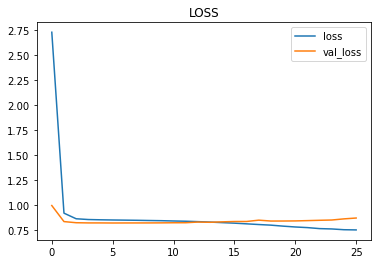

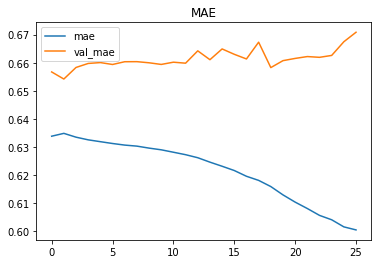

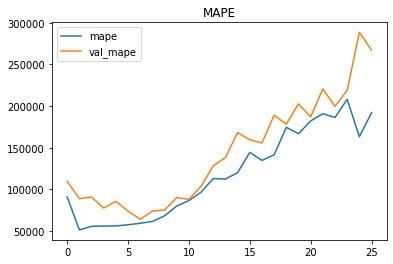

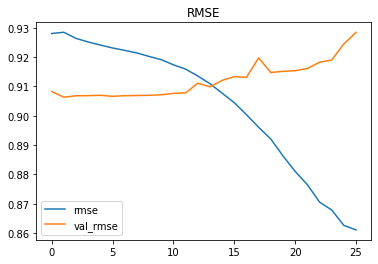

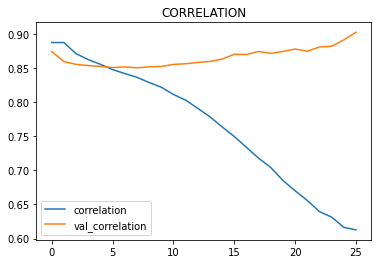

Pearson Score: 0.14848590297658662
Epoch 1/30
188/188 [==============================] - 9s 39ms/step - loss: 1.8120 - mse: 0.8411 - mae: 0.6424 - mape: 95927.5391 - rmse: 0.9171 - correlation: 0.8726 - val_loss: 0.8439 - val_mse: 0.8243 - val_mae: 0.6488 - val_mape: 117373.5078 - val_rmse: 0.9079 - val_correlation: 0.8630
Epoch 2/30
188/188 [==============================] - 3s 16ms/step - loss: 0.8500 - mse: 0.8436 - mae: 0.6433 - mape: 65870.6406 - rmse: 0.9185 - correlation: 0.8824 - val_loss: 0.8319 - val_mse: 0.8276 - val_mae: 0.6512 - val_mape: 125066.1562 - val_rmse: 0.9097 - val_correlation: 0.8634
Epoch 3/30
188/188 [==============================] - 3s 16ms/step - loss: 0.8442 - mse: 0.8420 - mae: 0.6426 - mape: 67747.1250 - rmse: 0.9176 - correlation: 0.8751 - val_loss: 0.8085 - val_mse: 0.8041 - val_mae: 0.6459 - val_mape: 67989.4375 - val_rmse: 0.8967 - val_correlation: 0.8627
Epoch 4/30
188/188 [==============================] - 3s 16ms/step - loss: 0.8395 - mse: 0.8364 

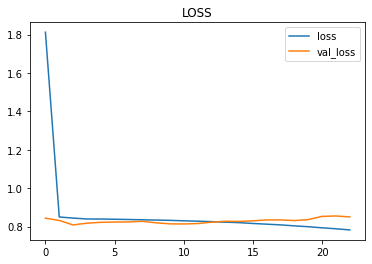

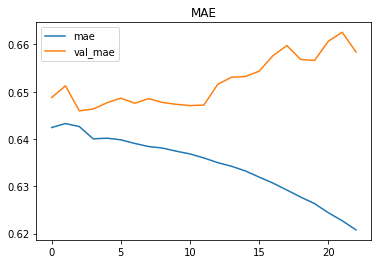

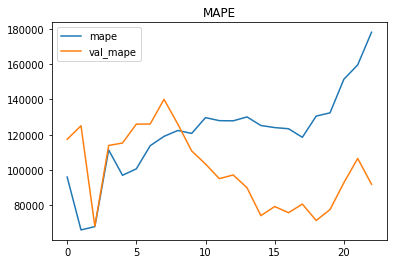

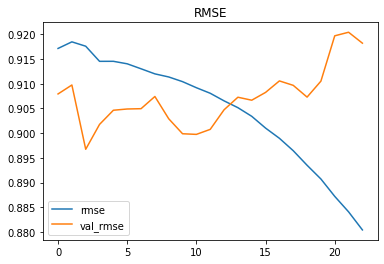

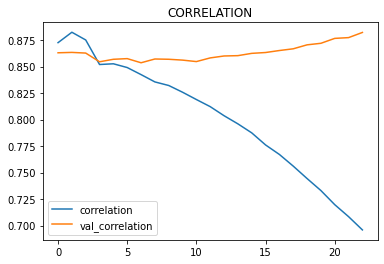

Pearson Score: 0.14716710484145284
Epoch 1/30
274/274 [==============================] - 11s 33ms/step - loss: 1.4909 - mse: 0.8260 - mae: 0.6452 - mape: 83100.4922 - rmse: 0.9089 - correlation: 0.8671 - val_loss: 0.8552 - val_mse: 0.8510 - val_mae: 0.6225 - val_mape: 96677.9844 - val_rmse: 0.9225 - val_correlation: 0.8800
Epoch 2/30
274/274 [==============================] - 4s 15ms/step - loss: 0.8245 - mse: 0.8218 - mae: 0.6437 - mape: 88600.6953 - rmse: 0.9065 - correlation: 0.8508 - val_loss: 0.8526 - val_mse: 0.8499 - val_mae: 0.6270 - val_mape: 95971.3750 - val_rmse: 0.9219 - val_correlation: 0.8756
Epoch 3/30
274/274 [==============================] - 4s 15ms/step - loss: 0.8214 - mse: 0.8189 - mae: 0.6423 - mape: 92551.7109 - rmse: 0.9049 - correlation: 0.8413 - val_loss: 0.8550 - val_mse: 0.8522 - val_mae: 0.6319 - val_mape: 89883.2891 - val_rmse: 0.9232 - val_correlation: 0.8781
Epoch 4/30
274/274 [==============================] - 4s 15ms/step - loss: 0.8194 - mse: 0.8170 -

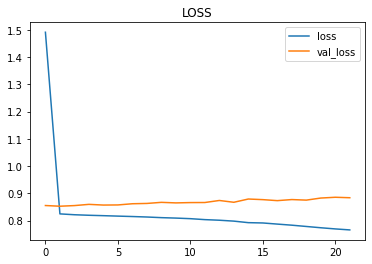

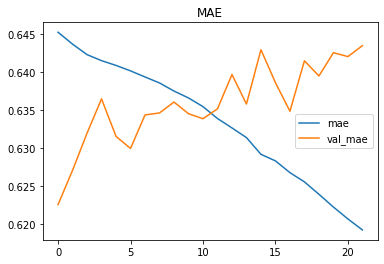

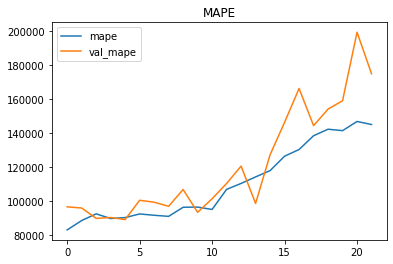

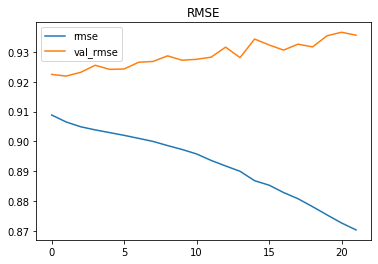

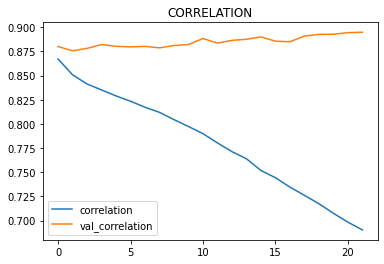

Pearson Score: 0.12436255712749322


In [ ]:
# models = []
# features = [f"f_{i}" for i in range(300)]
# gkf = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = group_gap)
# for fold, (tra_idx, val_idx) in tqdm(enumerate(gkf.split(train['investment_id'].values, train['investment_id'].values, train['time_id'].values)), total=n_splits):

#     valid_ds = make_train_dataset(train.loc[val_idx,features], train.loc[val_idx,'investment_id'], train.loc[val_idx,'target'])
#     model = get_model()
#     if config.is_training:
#         train_ds = make_train_dataset(train.loc[tra_idx, features], train.loc[tra_idx, 'investment_id'], train.loc[tra_idx, 'target'])
#         checkpoint = keras.callbacks.ModelCheckpoint(f"model_{fold}.tf", monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
#         early_stop = keras.callbacks.EarlyStopping(patience=20)
#         history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
#         model.load_weights(f"model_{fold}.tf")
#         for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
#             pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
#             plt.title(metric.upper())
#             plt.show()
#     else:
#         model.load_weights(f"{config.output_dataset_path}model_{fold}.tf")
#     y_vals = []
#     for _, y in valid_ds:
#         y_vals += list(y.numpy().reshape(-1))
#     y_val = np.array(y_vals)
#     pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
#     models.append(model)
#     print(f"Pearson Score: {pearson_score}")

In [9]:
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["investment_id"], item["features"]), item["target"]

def make_dataset(file_paths, batch_size=config.batch_size, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
data_path = config.tf_record_dataset_path
# train_path = f"{config.tf_record_dataset_path}fold_{0}_train.tfrecords"
train_path = data_path+"/fold_0_train.tfrecords"
tmp = make_dataset([train_path])

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1000
95/95 [==============================] - 17s 131ms/step - loss: 3.2762 - mse: 0.8621 - mae: 0.6347 - mape: 102937.4688 - rmse: 0.9285 - correlation: 0.8929 - val_loss: 1.0873 - val_mse: 0.8232 - val_mae: 0.6543 - val_mape: 100910.7500 - val_rmse: 0.9073 - val_correlation: 0.8678
Epoch 2/1000
95/95 [==============================] - 2s 17ms/step - loss: 0.9477 - mse: 0.8613 - mae: 0.6346 - mape: 58503.4102 - rmse: 0.9280 - correlation: 0.8824 - val_loss: 0.8434 - val_mse: 0.8211 - val_mae: 0.6535 - val_mape: 119261.3906 - val_rmse: 0.9061 - val_correlation: 0.8596
Epoch 3/1000
95/95 [==============================] - 2s 18ms/step - loss: 0.8702 - mse: 0.8595 - mae: 0.6339 - mape: 54678.4219 - rmse: 0.9271 - correlation: 0.8765 - val_loss: 0.8263 - val_mse: 0.8209 - val_mae: 0.6546 - val_mape: 108492.7031 - val_rmse: 0.9060 - val_correlation: 0.8566
Epoch 4/1000
95/95 [==============================] - 2s 17ms/step - loss: 0.8613 - mse: 0.8580 - mae: 0.6335 - mape: 59814.636

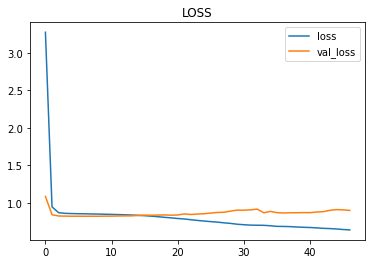

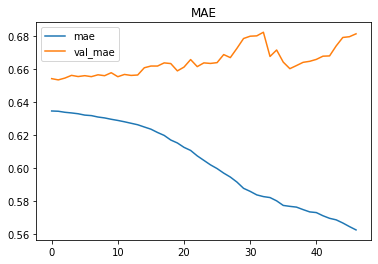

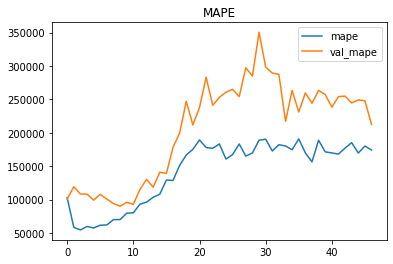

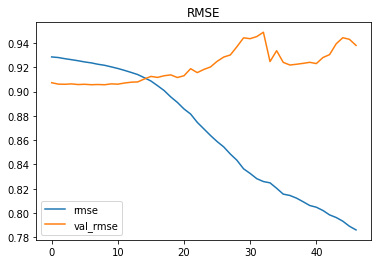

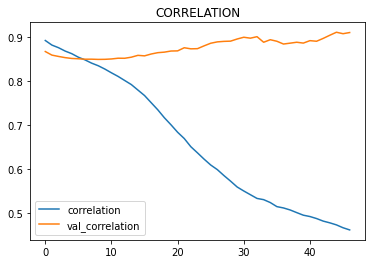

Pearson Score: 0.14963872441438109
Epoch 1/1000
188/188 [==============================] - 13s 62ms/step - loss: 2.1082 - mse: 0.8423 - mae: 0.6430 - mape: 100508.8438 - rmse: 0.9177 - correlation: 0.8796 - val_loss: 0.8575 - val_mse: 0.8336 - val_mae: 0.6484 - val_mape: 138397.4531 - val_rmse: 0.9130 - val_correlation: 0.8690
Epoch 2/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.8523 - mse: 0.8441 - mae: 0.6435 - mape: 68536.3906 - rmse: 0.9188 - correlation: 0.8811 - val_loss: 0.8331 - val_mse: 0.8295 - val_mae: 0.6480 - val_mape: 125948.1484 - val_rmse: 0.9108 - val_correlation: 0.8669
Epoch 3/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.8449 - mse: 0.8418 - mae: 0.6425 - mape: 77315.4062 - rmse: 0.9175 - correlation: 0.8722 - val_loss: 0.8278 - val_mse: 0.8240 - val_mae: 0.6473 - val_mape: 127126.6016 - val_rmse: 0.9077 - val_correlation: 0.8633
Epoch 4/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.8435 - m

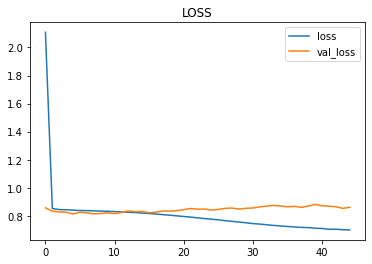

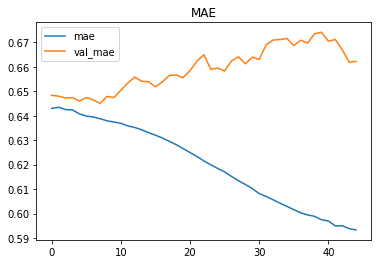

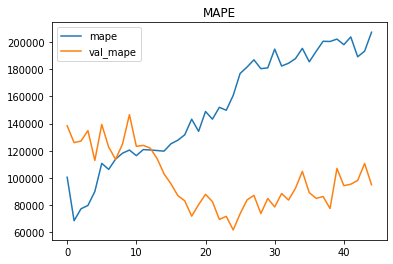

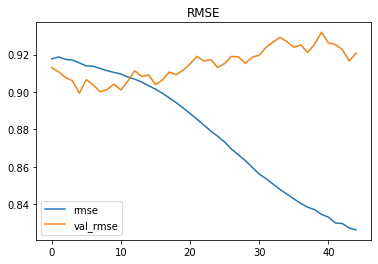

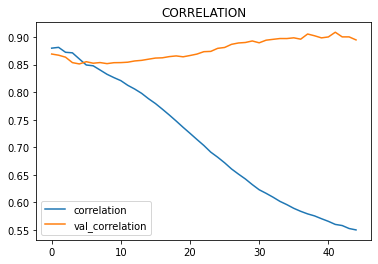

Pearson Score: 0.1479737600444982
Epoch 1/1000
274/274 [==============================] - 16s 56ms/step - loss: 1.6979 - mse: 0.8266 - mae: 0.6457 - mape: 82648.7188 - rmse: 0.9092 - correlation: 0.8712 - val_loss: 0.8567 - val_mse: 0.8516 - val_mae: 0.6225 - val_mape: 104931.2891 - val_rmse: 0.9228 - val_correlation: 0.8827
Epoch 2/1000
274/274 [==============================] - 4s 14ms/step - loss: 0.8254 - mse: 0.8225 - mae: 0.6440 - mape: 84709.7578 - rmse: 0.9069 - correlation: 0.8542 - val_loss: 0.8538 - val_mse: 0.8511 - val_mae: 0.6258 - val_mape: 115767.1875 - val_rmse: 0.9225 - val_correlation: 0.8806
Epoch 3/1000
274/274 [==============================] - 4s 14ms/step - loss: 0.8219 - mse: 0.8194 - mae: 0.6426 - mape: 87970.3984 - rmse: 0.9052 - correlation: 0.8436 - val_loss: 0.8551 - val_mse: 0.8524 - val_mae: 0.6291 - val_mape: 113973.3203 - val_rmse: 0.9232 - val_correlation: 0.8803
Epoch 4/1000
274/274 [==============================] - 4s 14ms/step - loss: 0.8198 - mse

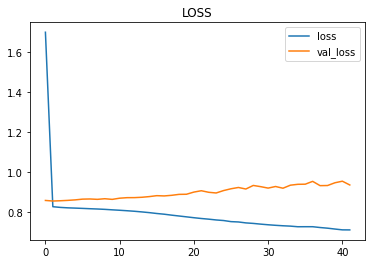

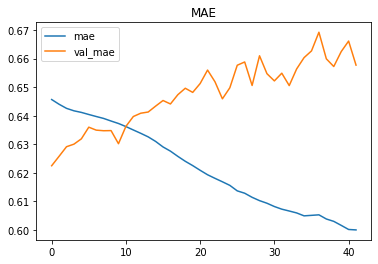

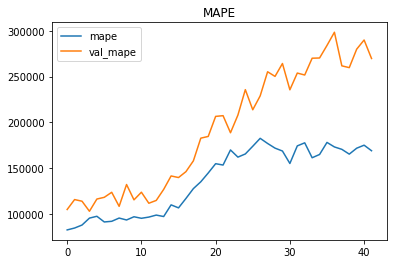

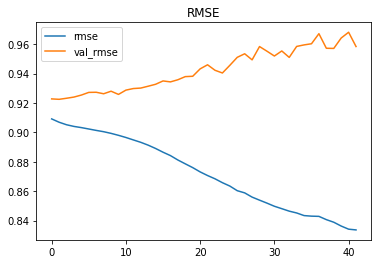

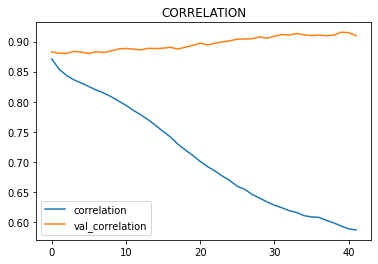

Pearson Score: 0.11930445619755589
Epoch 1/1000
381/381 [==============================] - 27s 67ms/step - loss: 1.4573 - mse: 0.8331 - mae: 0.6397 - mape: 82468.7109 - rmse: 0.9128 - correlation: 0.8713 - val_loss: 0.8514 - val_mse: 0.8488 - val_mae: 0.6154 - val_mape: 387950.9688 - val_rmse: 0.9213 - val_correlation: 0.8972
Epoch 2/1000
381/381 [==============================] - 5s 14ms/step - loss: 0.8312 - mse: 0.8288 - mae: 0.6379 - mape: 83035.9375 - rmse: 0.9104 - correlation: 0.8539 - val_loss: 0.8457 - val_mse: 0.8434 - val_mae: 0.6146 - val_mape: 279564.4688 - val_rmse: 0.9184 - val_correlation: 0.8931
Epoch 3/1000
381/381 [==============================] - 5s 13ms/step - loss: 0.8293 - mse: 0.8265 - mae: 0.6369 - mape: 90928.6797 - rmse: 0.9091 - correlation: 0.8444 - val_loss: 0.8464 - val_mse: 0.8441 - val_mae: 0.6151 - val_mape: 322203.1875 - val_rmse: 0.9188 - val_correlation: 0.8917
Epoch 4/1000
381/381 [==============================] - 5s 14ms/step - loss: 0.8277 - ms

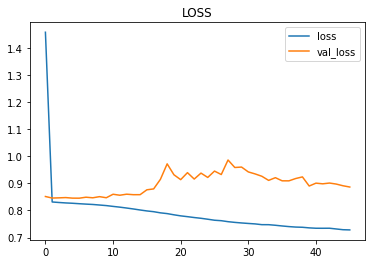

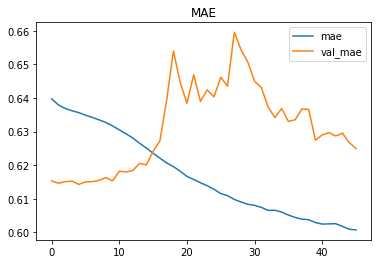

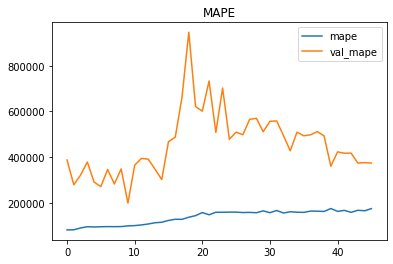

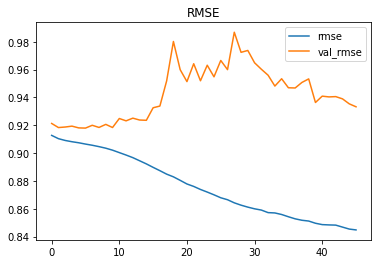

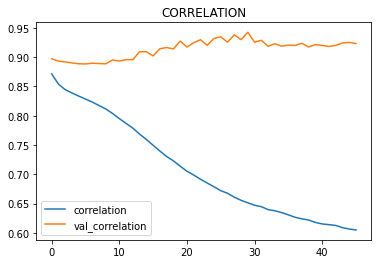

Pearson Score: 0.11193330324342451
Epoch 1/1000
499/499 [==============================] - 21s 39ms/step - loss: 1.3140 - mse: 0.8356 - mae: 0.6344 - mape: 119506.2500 - rmse: 0.9141 - correlation: 0.8755 - val_loss: 0.8613 - val_mse: 0.8586 - val_mae: 0.6263 - val_mape: 269822.5312 - val_rmse: 0.9266 - val_correlation: 0.8855
Epoch 2/1000
499/499 [==============================] - 7s 13ms/step - loss: 0.8340 - mse: 0.8315 - mae: 0.6328 - mape: 133272.5312 - rmse: 0.9119 - correlation: 0.8600 - val_loss: 0.8595 - val_mse: 0.8575 - val_mae: 0.6248 - val_mape: 241318.5625 - val_rmse: 0.9260 - val_correlation: 0.8837
Epoch 3/1000
499/499 [==============================] - 6s 13ms/step - loss: 0.8320 - mse: 0.8295 - mae: 0.6320 - mape: 143670.6406 - rmse: 0.9108 - correlation: 0.8525 - val_loss: 0.8606 - val_mse: 0.8582 - val_mae: 0.6246 - val_mape: 267612.0000 - val_rmse: 0.9264 - val_correlation: 0.8838
Epoch 4/1000
499/499 [==============================] - 6s 13ms/step - loss: 0.8305 -

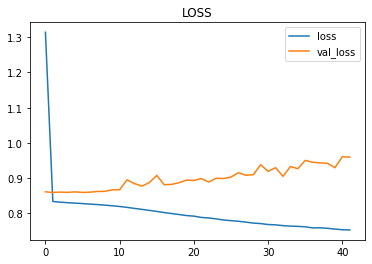

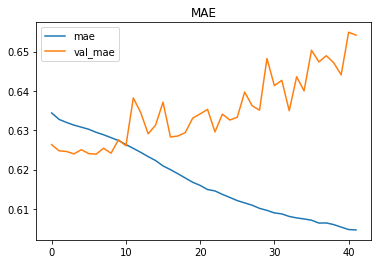

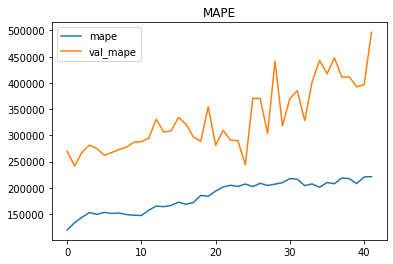

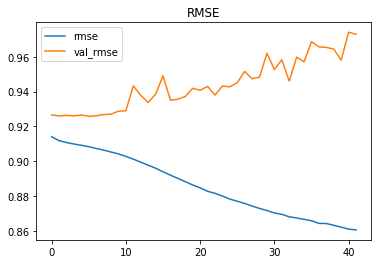

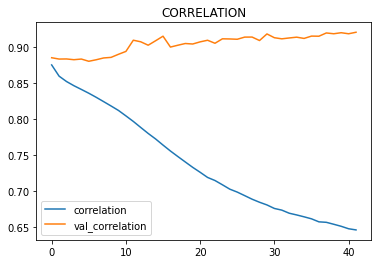

Pearson Score: 0.11966455250912142
Epoch 1/1000
629/629 [==============================] - 23s 35ms/step - loss: 1.2212 - mse: 0.8400 - mae: 0.6321 - mape: 122682.4531 - rmse: 0.9165 - correlation: 0.8770 - val_loss: 0.8064 - val_mse: 0.8040 - val_mae: 0.5937 - val_mape: 69311.9609 - val_rmse: 0.8967 - val_correlation: 0.8744
Epoch 2/1000
629/629 [==============================] - 8s 13ms/step - loss: 0.8383 - mse: 0.8360 - mae: 0.6305 - mape: 145495.2031 - rmse: 0.9143 - correlation: 0.8609 - val_loss: 0.8046 - val_mse: 0.8024 - val_mae: 0.5931 - val_mape: 70991.1953 - val_rmse: 0.8958 - val_correlation: 0.8670
Epoch 3/1000
629/629 [==============================] - 8s 13ms/step - loss: 0.8363 - mse: 0.8339 - mae: 0.6297 - mape: 160850.8438 - rmse: 0.9132 - correlation: 0.8531 - val_loss: 0.8037 - val_mse: 0.8015 - val_mae: 0.5926 - val_mape: 73138.8750 - val_rmse: 0.8952 - val_correlation: 0.8620
Epoch 4/1000
629/629 [==============================] - 8s 13ms/step - loss: 0.8351 - ms

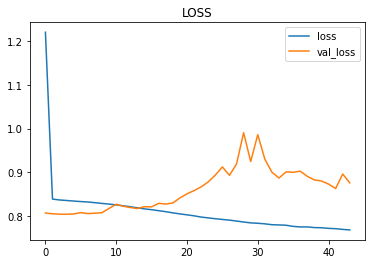

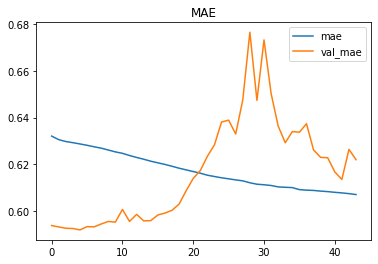

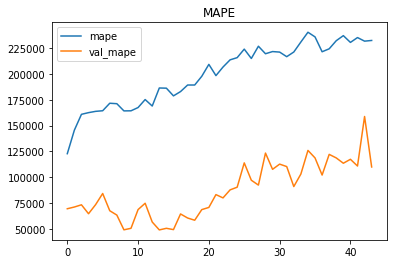

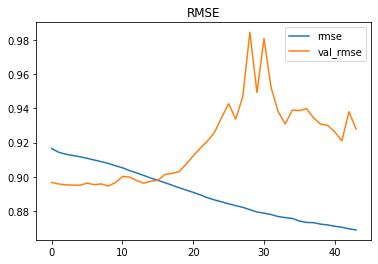

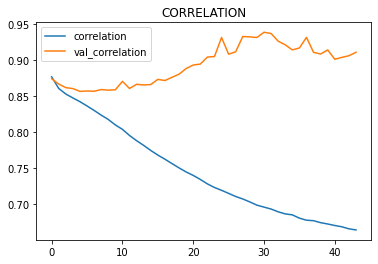

Pearson Score: 0.1447858520194239


In [ ]:
models = []
data_path = Path(config.tf_record_dataset_path)
save_path = Path(config.output_dataset_path)
log = 
for i in tqdm(range(config.n_splits), total=config.n_splits):
    print(f'=======================fold : {i}=======================')
    train_path = f"{config.tf_record_dataset_path}/fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}/fold_{i}_test.tfrecords"
    valid_ds = make_dataset([valid_path], mode="valid")
    model = get_model()
    if config.is_training:
        train_ds = make_dataset([train_path])
        batch_length = len(list(train_ds))
        checkpoint = keras.callbacks.ModelCheckpoint(f"{config.output_dataset_path}/{config.model}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf"\
                                                     , monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=config.patience)
        # scheduler = keras.callbacks.LearningRateScheduler(config.lr_scheduler)
        lr, ts, wlr, ws, hbrs = config.warm_up_lr(config.batch_size*batch_length)
        lr_scheduler = eval(config.lr_scheduler)(learning_rate_base = lr,
                                           total_steps = ts,
                                           warmup_steps = ws,
                                           hold_base_rate_steps=hbrs)
        history = model.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, early_stop, lr_scheduler])
        model.load_weights(f"{config.output_dataset_path}/{config.model}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf")
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}/model_{i}.tf")
    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
    models.append(model)
    print(f"Pearson Score: {pearson_score}")

## Submission

In [ ]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
features = [f"f_{i}" for i in range(300)]
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 